In [1]:
import pandas as pd
data = pd.read_csv('File Data/loan_data_2007_2014.csv')
data.info()

/home/vivin/.local/lib/python3.8/site-packages/IPython/core/interactiveshell.py:3135: DtypeWarning: Columns (20) have mixed types.Specify dtype option on import or set low_memory=False.
  has_raised = await self.run_ast_nodes(code_ast.body, cell_name,


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 466285 entries, 0 to 466284
Data columns (total 75 columns):
 #   Column                       Non-Null Count   Dtype  
---  ------                       --------------   -----  
 0   Unnamed: 0                   466285 non-null  int64  
 1   id                           466285 non-null  int64  
 2   member_id                    466285 non-null  int64  
 3   loan_amnt                    466285 non-null  int64  
 4   funded_amnt                  466285 non-null  int64  
 5   funded_amnt_inv              466285 non-null  float64
 6   term                         466285 non-null  object 
 7   int_rate                     466285 non-null  float64
 8   installment                  466285 non-null  float64
 9   grade                        466285 non-null  object 
 10  sub_grade                    466285 non-null  object 
 11  emp_title                    438697 non-null  object 
 12  emp_length                   445277 non-null  object 
 13 

In [2]:
# Membuang kolom yang tidak perlu
colomYangTidakPerlu = ['id','member_id','funded_amnt_inv','sub_grade','emp_title','url','desc','zip_code','Unnamed: 0','title','next_pymnt_d', 'recoveries', 'collection_recovery_fee','total_rec_prncp', 'total_rec_late_fee','policy_code']
data.drop(colomYangTidakPerlu, axis=1, inplace=True)

# Membuang kolom yang memiliki missing value lebih dari 80%
data.dropna(thresh = data.shape[0]*0.2, how = 'all', axis = 1, inplace = True)

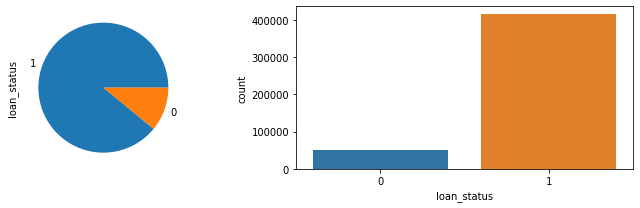

In [3]:
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

#Mengklasifikasikan target menjadi 2, yaitu 0 untuk kredit yang berisiko dan 1 untuk kredit yang tidak berisiko
data['loan_status']= np.where(data['loan_status'].isin(['Charged Off', 'Default', 'Late (31-120 days)','Does not meet the credit policy. Status:Charged Off']),0,1 )

fig= plt.figure(figsize=(10,3) )
fig.add_subplot(1,2,1)
a= data["loan_status"].value_counts(normalize=True).plot.pie()
fig.add_subplot(1,2,2)
churnchart=sns.countplot(x=data["loan_status"])
plt.tight_layout()
plt.show()

In [4]:
from sklearn.model_selection import train_test_split
from scipy.stats import chi2_contingency

y = data['loan_status']
X = data.copy()
X.drop(labels=['loan_status'], axis=1, inplace=True)
X_train, X_valid, y_train, y_valid = train_test_split(X,y, test_size=0.2)

# Kolom data ketegori yang rendah kardinalitasnya
catKolom = [cols for cols in X_train.columns if X_train[cols].dtype == 'object' and X_train[cols].nunique() < 10]
catKolom

# kolom tipe numerik
numKolom = [cols for cols in X_train.columns if X_train[cols].dtype in ['float64', 'int64']]
numKolom

chi2_col = []
chi2_p = []

# Menghitung nilai chi2
for column in X_train[catKolom]:
    chi, p, dof, ex = chi2_contingency(pd.crosstab(y_train, X_train[column]))
    chi2_col.append(column)
    chi2_p.append(round(p,10))

chi2_value = {
    'kolom' : chi2_col,
    'pValue' : chi2_p
}

chi2 = pd.DataFrame(chi2_value)
chi2

,kolom,pValue
0,term,0.000000
1,grade,0.000000
2,home_ownership,0.000000
3,verification_status,0.000000
4,pymnt_plan,0.007103
5,initial_list_status,0.000000
6,application_type,1.000000


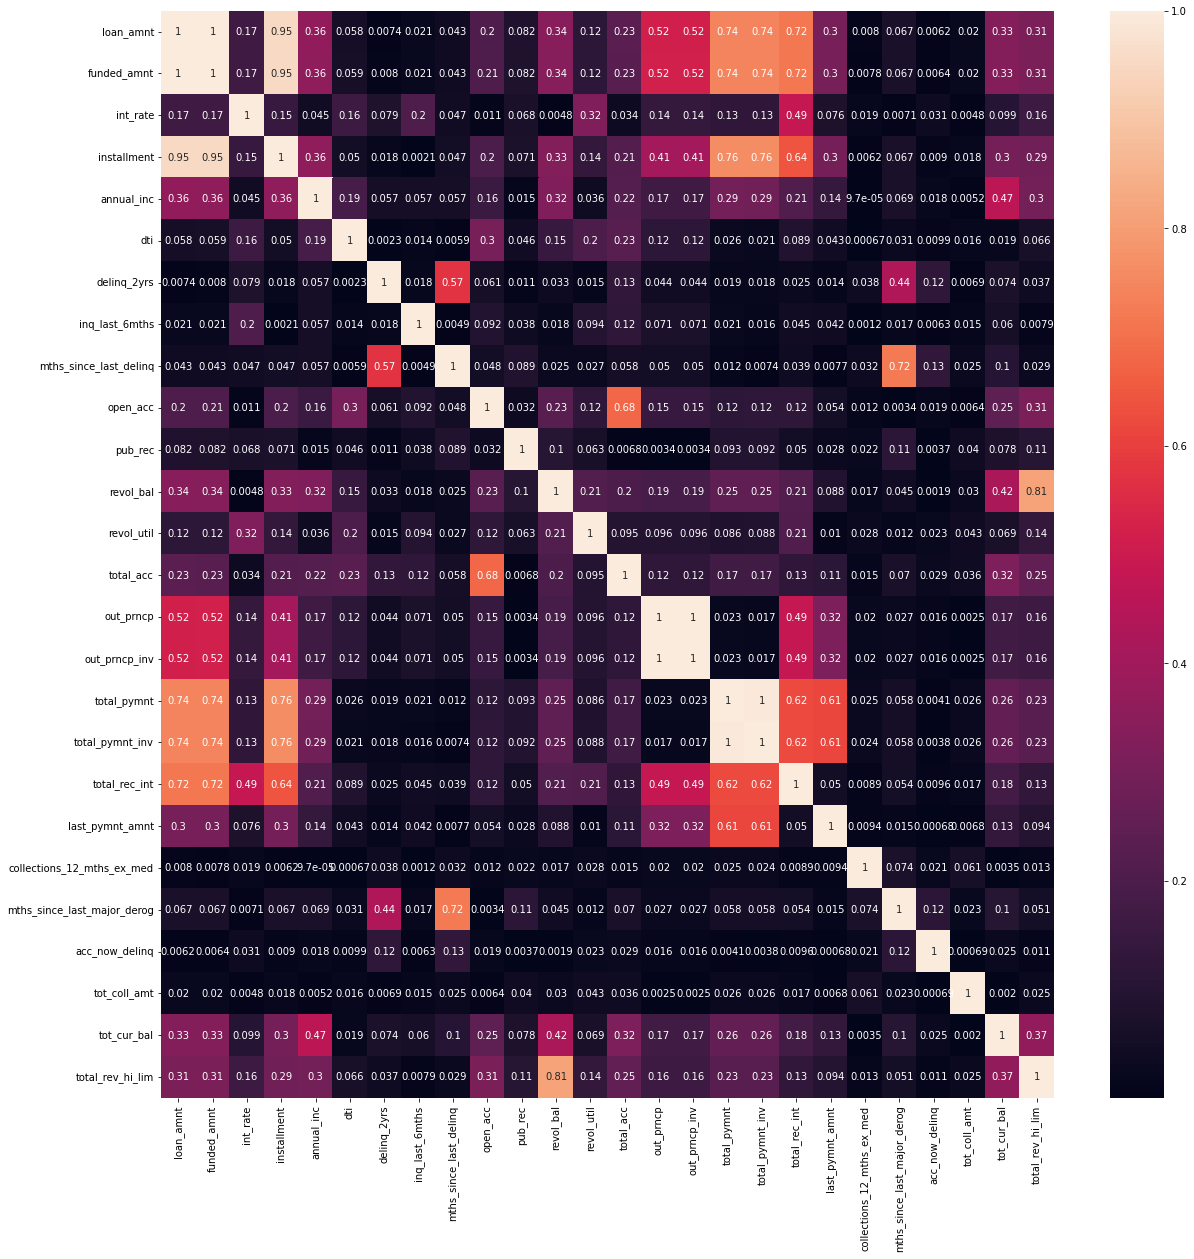

In [5]:
# Head map bagi kolom numerik
corr = X_train[numKolom].corr().abs()
plt.figure(figsize=(20,20))
ax = sns.heatmap(corr,annot=True)
plt.show()

In [6]:
# Membuang kolom numeric dengan korelasi lebih dari 0,7
upper = corr.where(np.triu(np.ones(corr.shape),k=1).astype(np.bool))
to_drop_num = [cols for cols in upper.columns if any(upper[cols]>0.7)]

for i in to_drop_num :
    numKolom.remove(i)

# Membuang kolom kategori dengan niai p-value yang tinggi
catKolom.remove('pymnt_plan')
catKolom.remove('application_type')

# Features
features = numKolom + catKolom
X_train = X_train[features]
X_valid = X_valid[features]

In [7]:
X_train.columns

Index(['loan_amnt', 'int_rate', 'annual_inc', 'dti', 'delinq_2yrs',
       'inq_last_6mths', 'mths_since_last_delinq', 'open_acc', 'pub_rec',
       'revol_bal', 'revol_util', 'total_acc', 'out_prncp', 'last_pymnt_amnt',
       'collections_12_mths_ex_med', 'acc_now_delinq', 'tot_coll_amt',
       'tot_cur_bal', 'term', 'grade', 'home_ownership', 'verification_status',
       'initial_list_status'],
      dtype='object')

In [116]:
# Membuat Pipline
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import OrdinalEncoder
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestRegressor

# Preprosessing for numerical data
numerical = SimpleImputer(strategy='mean')

# Categorial preprossesing
categorial = Pipeline(steps=[
    ('imputer',SimpleImputer(strategy='constant')),
    ('ordinal', OrdinalEncoder())
    ])

preprocessor = ColumnTransformer(
    transformers=[
        ('num', numerical, list(numKolom)),
        ('cat', categorial, catKolom)
    ])

model = LogisticRegression()

my_piplines = Pipeline(steps=[
    ('preprocessor', preprocessor),
    ('model', model)
])

In [117]:
my_piplines.fit(X_train, y_train)
predic = my_piplines.predict(X_valid)

/home/vivin/.local/lib/python3.8/site-packages/sklearn/linear_model/_logistic.py:444: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


In [118]:
from sklearn.metrics import confusion_matrix
cf_matrix = confusion_matrix(y_valid, predic)
cf_matrix


array([[ 2809,  7266],
       [ 1660, 81522]])

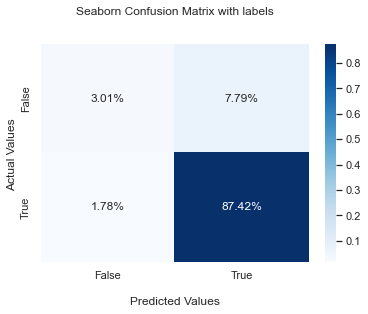

In [119]:
# Confusion matrix plot

ax = sns.heatmap(cf_matrix/np.sum(cf_matrix), annot=True, 
            fmt='.2%', cmap='Blues')

ax.set_title('Seaborn Confusion Matrix with labels\n\n');
ax.set_xlabel('\nPredicted Values')
ax.set_ylabel('Actual Values ');

## Ticket labels - List must be in alphabetical order
ax.xaxis.set_ticklabels(['False','True'])
ax.yaxis.set_ticklabels(['False','True'])

## Display the visualization of the Confusion Matrix.
plt.show()